# Applied Machine Learning: Module 4 (Supervised Learning, Part II)

## Preamble and Datasets

In [1]:
!wget -P data https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/fruit_data_with_colors.txt https://raw.githubusercontent.com/slundberg/shap/master/data/CommViolPredUnnormalizedData.txt

--2022-09-04 18:34:51--  https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/fruit_data_with_colors.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2370 (2.3K) [text/plain]
Saving to: 'data/fruit_data_with_colors.txt.3'

     0K ..                                                    100% 2.04M=0.001s

2022-09-04 18:34:51 (2.04 MB/s) - 'data/fruit_data_with_colors.txt.3' saved [2370/2370]

--2022-09-04 18:34:51--  https://raw.githubusercontent.com/slundberg/shap/master/data/CommViolPredUnnormalizedData.txt
Reusing existing connection to raw.githubusercontent.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 1557736 (1.5M) [text/plain]
Saving to: 'data/CommViolPredUnnormalizedData.txt.3'

     0K .......... ......

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

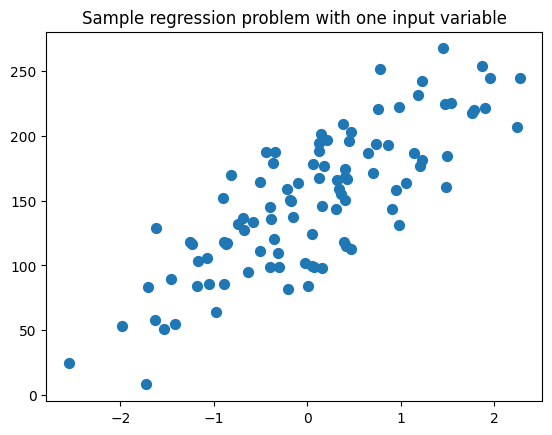

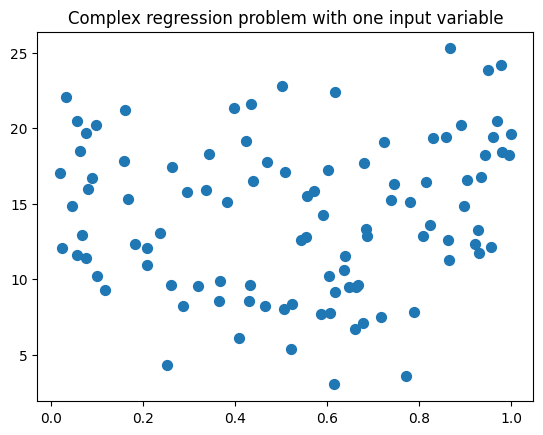

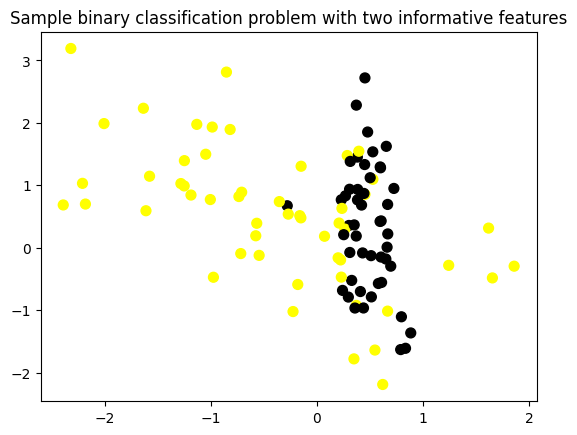

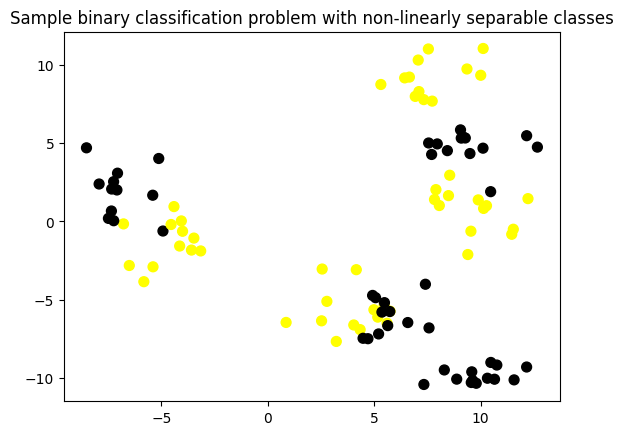

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_blobs
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.datasets import load_breast_cancer

# from adspy_shared_utilities import load_crime_dataset

def load_crime_dataset():
    # Communities and Crime dataset for regression
    # https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized

    crime = pd.read_table('./data/CommViolPredUnnormalizedData.txt', sep=',', na_values='?')
    # remove features with poor coverage or lower relevance, and keep ViolentCrimesPerPop target column
    columns_to_keep = [5, 6] + list(range(11,26)) + list(range(32, 103)) + [145]  
    crime = crime.iloc[:,columns_to_keep].dropna()

    X_crime = crime.iloc[:,range(0,88)]
    y_crime = crime['ViolentCrimesPerPop']

    return (X_crime, y_crime)

cmap_bold = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])

# fruits dataset
fruits = pd.read_table('./data/fruit_data_with_colors.txt')

feature_names_fruits = ['height', 'width', 'mass', 'color_score']
X_fruits = fruits[feature_names_fruits]
y_fruits = fruits['fruit_label']
target_names_fruits = ['apple', 'mandarin', 'orange', 'lemon']

X_fruits_2d = fruits[['height', 'width']]
y_fruits_2d = fruits['fruit_label']

# synthetic dataset for simple regression
from sklearn.datasets import make_regression
plt.figure()
plt.title('Sample regression problem with one input variable')
X_R1, y_R1 = make_regression(n_samples = 100, n_features=1,
                            n_informative=1, bias = 150.0,
                            noise = 30, random_state=0)
plt.scatter(X_R1, y_R1, marker= 'o', s=50)
plt.show()

# synthetic dataset for more complex regression
from sklearn.datasets import make_friedman1
plt.figure()
plt.title('Complex regression problem with one input variable')
X_F1, y_F1 = make_friedman1(n_samples = 100, n_features = 7,
                           random_state=0)

plt.scatter(X_F1[:, 2], y_F1, marker= 'o', s=50)
plt.show()

# synthetic dataset for classification (binary)
plt.figure()
plt.title('Sample binary classification problem with two informative features')
X_C2, y_C2 = make_classification(n_samples = 100, n_features=2,
                                n_redundant=0, n_informative=2,
                                n_clusters_per_class=1, flip_y = 0.1,
                                class_sep = 0.5, random_state=0)
plt.scatter(X_C2[:, 0], X_C2[:, 1], marker= 'o',
           c=y_C2, s=50, cmap=cmap_bold)
plt.show()

# more difficult synthetic dataset for classification (binary)
# with classes that are not linearly separable
X_D2, y_D2 = make_blobs(n_samples = 100, n_features = 2,
                       centers = 8, cluster_std = 1.3,
                       random_state = 4)
y_D2 = y_D2 % 2
plt.figure()
plt.title('Sample binary classification problem with non-linearly separable classes')
plt.scatter(X_D2[:,0], X_D2[:,1], c=y_D2,
           marker= 'o', s=50, cmap=cmap_bold)
plt.show()

# Breast cancer dataset for classification
cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

# Communities and Crime dataset
(X_crime, y_crime) = load_crime_dataset()

## Ensembles of Decision Trees

### Random forests

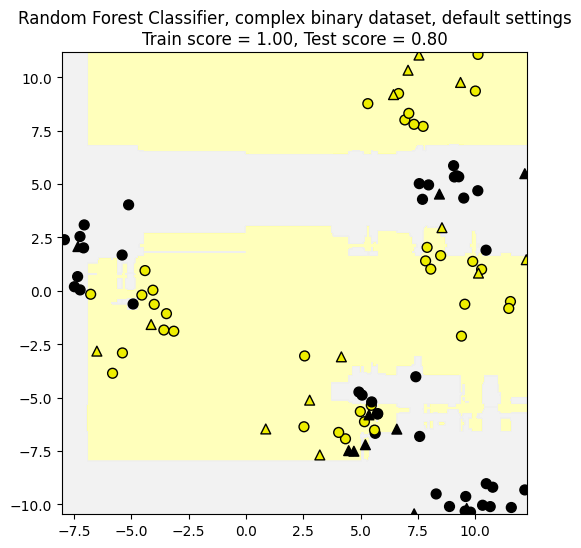

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

def plot_class_regions_for_classifier_subplot(clf, X, y, X_test, y_test, title, subplot, target_names = None, plot_decision_regions = True):

    numClasses = np.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = np.meshgrid(np.arange(x_min-k, x_max+k, h), np.arange(y_min-k, y_max+k, h))

    P = clf.predict(np.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)

    if plot_decision_regions:
        subplot.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    subplot.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    subplot.set_xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    subplot.set_ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        subplot.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    subplot.set_title(title)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        subplot.legend(loc=0, handles=legend_handles)

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2,
                                                   random_state = 0)
fig, subaxes = plt.subplots(1, 1, figsize=(6, 6))

clf = RandomForestClassifier().fit(X_train, y_train)
title = 'Random Forest Classifier, complex binary dataset, default settings'
plot_class_regions_for_classifier_subplot(clf, X_train, y_train, X_test,
                                         y_test, title, subaxes)

plt.show()

### Random forest: Fruit dataset

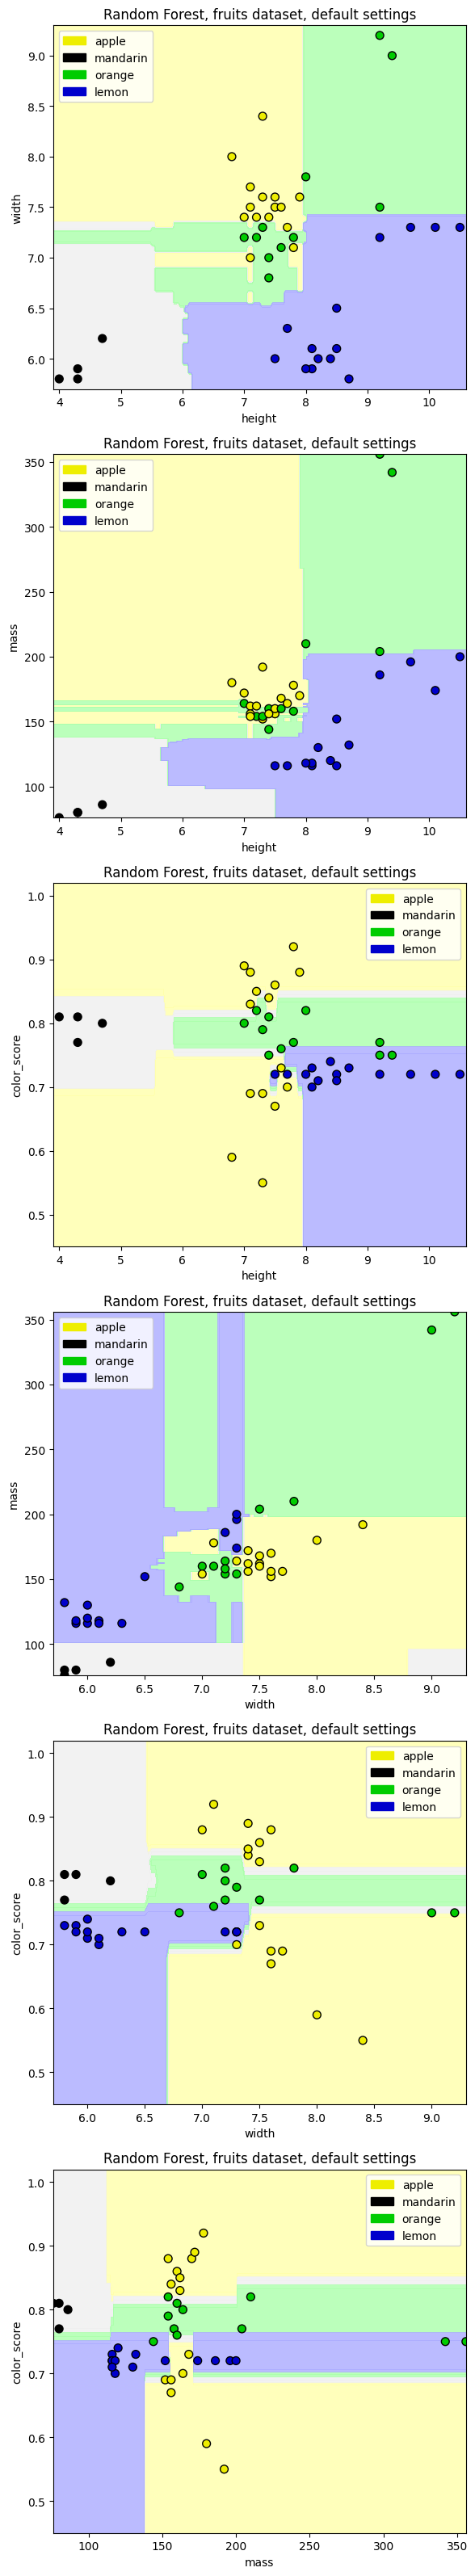

Random Forest, Fruit dataset, default settings
Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.80


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

X_train, X_test, y_train, y_test = train_test_split(X_fruits.values,
                                                   y_fruits.values,
                                                   random_state = 0)
fig, subaxes = plt.subplots(6, 1, figsize=(6, 32))

title = 'Random Forest, fruits dataset, default settings'
pair_list = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]

for pair, axis in zip(pair_list, subaxes):
    X = X_train[:, pair]
    y = y_train
    
    clf = RandomForestClassifier().fit(X, y)
    plot_class_regions_for_classifier_subplot(clf, X, y, None,
                                             None, title, axis,
                                             target_names_fruits)
    
    axis.set_xlabel(feature_names_fruits[pair[0]])
    axis.set_ylabel(feature_names_fruits[pair[1]])
    
plt.tight_layout()
plt.show()

clf = RandomForestClassifier(n_estimators = 10,
                            random_state=0).fit(X_train, y_train)

print('Random Forest, Fruit dataset, default settings')
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

#### Random Forests on a real-world dataset

In [6]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

clf = RandomForestClassifier(max_features = 8, random_state = 0)
clf.fit(X_train, y_train)

print('Breast cancer dataset')
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Breast cancer dataset
Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.97


### Gradient-boosted decision trees

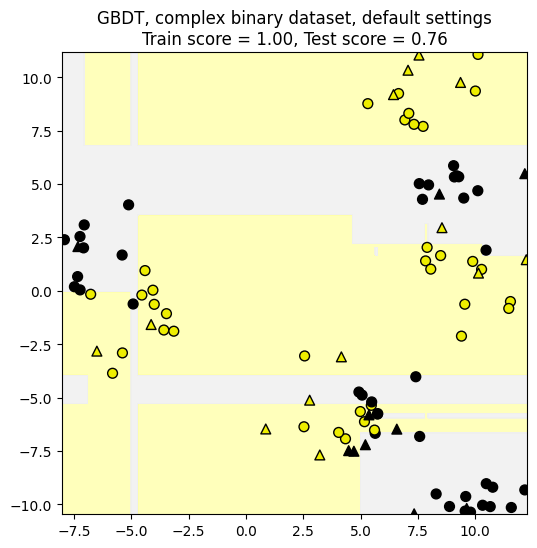

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
# from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state = 0)
fig, subaxes = plt.subplots(1, 1, figsize=(6, 6))

clf = GradientBoostingClassifier().fit(X_train, y_train)
title = 'GBDT, complex binary dataset, default settings'
plot_class_regions_for_classifier_subplot(clf, X_train, y_train, X_test,
                                         y_test, title, subaxes)

plt.show()

#### Gradient boosted decision trees on the fruit dataset

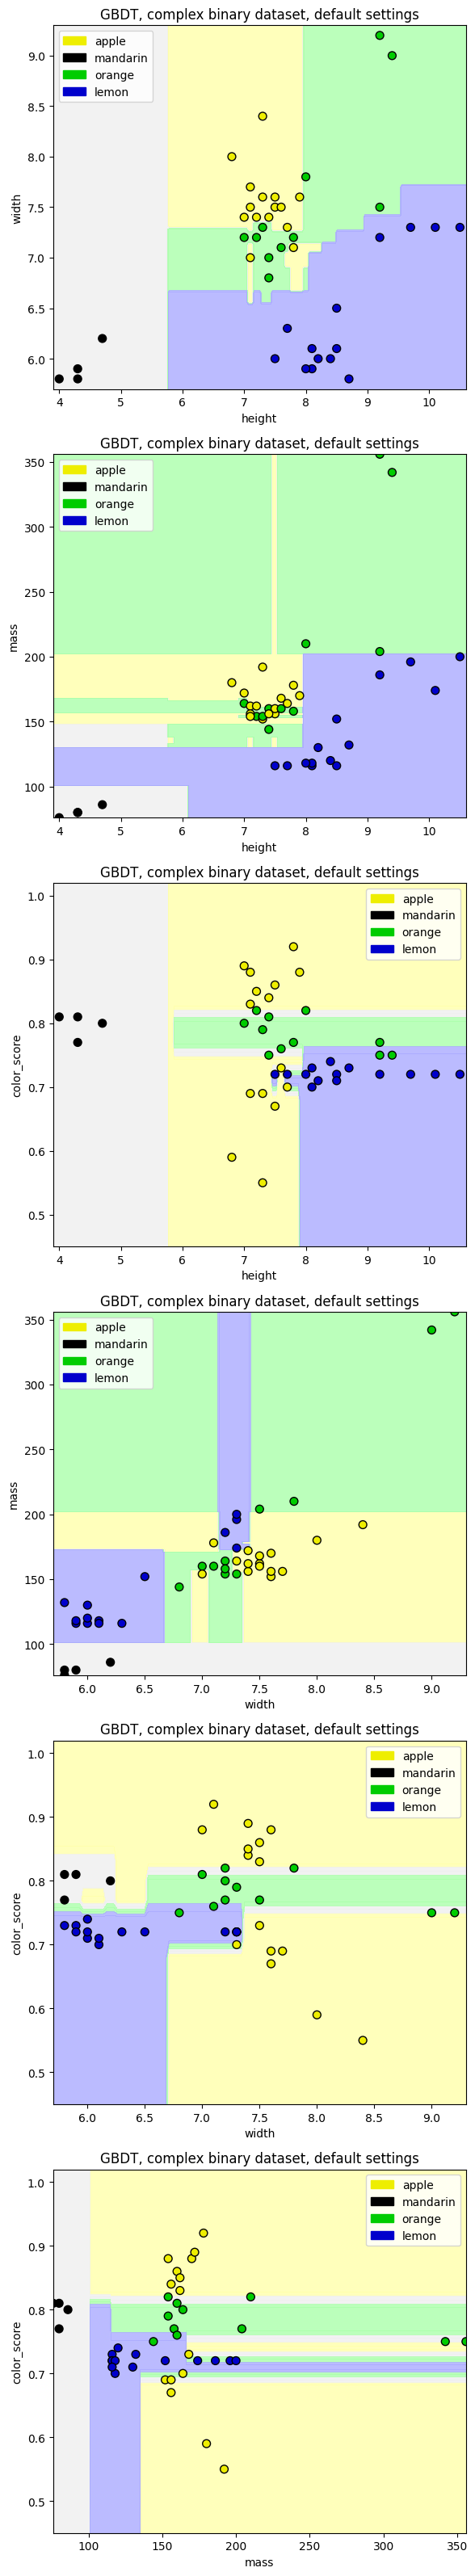

GBDT, Fruit dataset, default settings
Accuracy of GBDT classifier on training set: 1.00
Accuracy of GBDT classifier on test set: 0.80


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_fruits.values,
                                                   y_fruits.values,
                                                   random_state = 0)
fig, subaxes = plt.subplots(6, 1, figsize=(6, 32))

pair_list = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]

for pair, axis in zip(pair_list, subaxes):
    X = X_train[:, pair]
    y = y_train
    
    clf = GradientBoostingClassifier().fit(X, y)
    plot_class_regions_for_classifier_subplot(clf, X, y, None,
                                             None, title, axis,
                                             target_names_fruits)
    
    axis.set_xlabel(feature_names_fruits[pair[0]])
    axis.set_ylabel(feature_names_fruits[pair[1]])
    
plt.tight_layout()
plt.show()
clf = GradientBoostingClassifier().fit(X_train, y_train)

print('GBDT, Fruit dataset, default settings')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

#### Gradient-boosted decision trees on a real-world dataset

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

clf = GradientBoostingClassifier(random_state = 0)
clf.fit(X_train, y_train)

print('Breast cancer dataset (learning_rate=0.1, max_depth=3)')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}\n'
     .format(clf.score(X_test, y_test)))

clf = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 2, random_state = 0)
clf.fit(X_train, y_train)

print('Breast cancer dataset (learning_rate=0.01, max_depth=2)')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Breast cancer dataset (learning_rate=0.1, max_depth=3)
Accuracy of GBDT classifier on training set: 1.00
Accuracy of GBDT classifier on test set: 0.97

Breast cancer dataset (learning_rate=0.01, max_depth=2)
Accuracy of GBDT classifier on training set: 0.97
Accuracy of GBDT classifier on test set: 0.97
